## Inverse Problem

This notebook is a simple example of how to solve an inverse problem using pyshdom. It assumes that we have run the 'SimulateRadiances' notebook and saved the result.

In [1]:
#imports

import pyshdom
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
np.random.seed(1)


### Load Measurements

Here we load the synthetic measurements and also all of the inputs to the solver. We will use several of these inputs to perform 'inverse crimes' whereby we fix some aspects of the problem perfectly as in the forward simulation. When using real world measurements no such short cuts are necessary.

* First, we have to look at the measurements and select a region of interest and define our `rte_grid`. 
* Then we have to model the sensor sub-pixel geometry.
* We need to analyze whether the grid and sensor geometry are consistent. The SpaceCarver is useful for this. If not then we may need to change resolution of `rte_grid` to match the resolution of the measurements etc.
* We need to decide how to represent the surface, which is currently fixed.
* We need to decide how to represent the atmosphere.
    * What scattering species are we modelling? What are their optical models? 
    * Which quantities will be unknowns and which are fixed?
    * What will be the abstract state that we will reconstruct? For this we need to set the mapping between the abstract state and the RTE solver.
* Now that we are organized we need to initialize our state vector of unknowns. The method for this initialization may itself be quite involved as starting nearer the answer is better. This typically goes hand in hand with the selection of any fixed variables.
* Lastly we perform the optimization.

In this tutorial we will reconstruct only the `extinction` and we will use forward quantities from the ground truth synthetic measurements for simplicity.

In [2]:
sensors, solvers, rte_grid = pyshdom.util.load_forward_model('./SimulateRadiances.nc')

In [3]:
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=np.int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=np.int)
    ray_mask_pixel[np.where(sensor.I.data > 1e-4)] = 1

    copied['weights'] = ('nrays',np.ones(sensor.nrays.size))#[sensor.pixel_index.data])
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

extinction = pyshdom.initialization.mean_ext_estimate(rte_grid,sensor_list, solvers[0.86]._solarmu, 
                                                      solvers[0.86]._solaraz,sun_distance_reflect=0.1,
                     sun_distance_transmit=0.1)
extinction.extinction[0] = extinction.extinction[-1] =extinction.extinction[:,0] =extinction.extinction[:,-1] = 0.0

In [24]:

# only take MSPI observations.
for name in sensors:
    if name != 'MSPI':
        sensors.popitem(name)
        
# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# add an uncertainty model to the observations.
uncertainty = pyshdom.uncertainties.Uncertainty(np.diag(np.array([1e6,0.0,0.0,0.0])),'L2')
#uncertainty = pyshdom.uncertainties.DoLPUncertainty(0.0001, 0.001)
sensors.add_uncertainty_model('MSPI', uncertainty)

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_parameters[key] = solvers[key].numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': asdfadsf}


In [25]:
# set the generator for the unknown scatterer using ground truth optical properties
# and unknown extinction.
# OpticalGenerator holds the fixed optical properties and forms a full set of optical properties
# when it is called with extinction as the argument.

# MicrophysicalGenerator does the same but taking microphysics as the input. However that
# needs an OpticalPropertyGenerator to map between microphysics and optical properties as well.
optprop = solvers[0.86].medium['cloud'].copy(deep=True)
optprop = optprop.drop_vars('extinction')

deriv_gen = pyshdom.medium.OpticalGenerator(rte_grid,'cloud', 0.86, optprop)

# UnknownScatterers is a container for all of the unknown variables.
unknown_scatterers = pyshdom.containers.UnknownScatterers()
unknown_scatterers.add_unknowns(['extinction'], deriv_gen)

In [26]:
# now we form state_gen which updates the solvers with an input_state.
# Note that `pyshdom.medium.StateGenerator` also takes as inputs a state_transform, a state_representation
# and a state_to_grid objects. These objects handle multi-variable
solvers_reconstruct = pyshdom.containers.SolversDict()
mask = np.zeros((rte_grid.x.size,rte_grid.y.size,rte_grid.z.size)).astype(np.bool)
mask[np.where(extinction.extinction.data > 0.0)] = 1.0
state_gen = pyshdom.medium.StateGenerator(solvers_reconstruct,
                                         unknown_scatterers, rte_grid,surfaces,
                                         numerical_parameters, sources, background_optical_scatterers,
                                         num_stokes, state_transform=None, state_to_grid=mask)

In [27]:
# get bounds automatically.
min_bounds, max_bounds = state_gen.transform_bounds()

In [28]:
# transform initial physical state to abstract state. 
# This is
x0 = extinction.extinction.data
x0 = state_gen._state_to_grid.inverse(x0, 'cloud', 'extinction')
x0 = state_gen.state_transform.inverse(x0)

In [18]:
x0

array([29.9956639, 29.9956639, 29.9956639, ..., 29.9956639, 29.9956639,
       29.9956639])

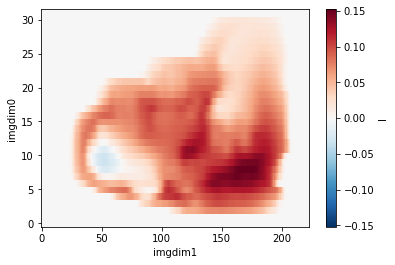

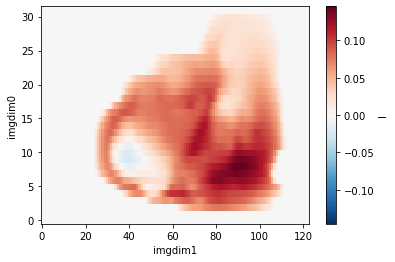

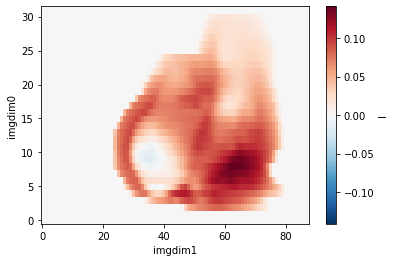

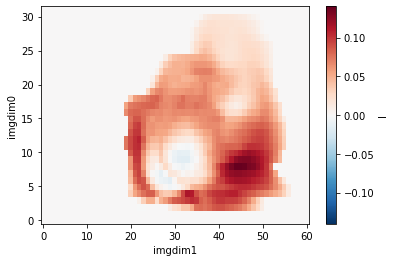

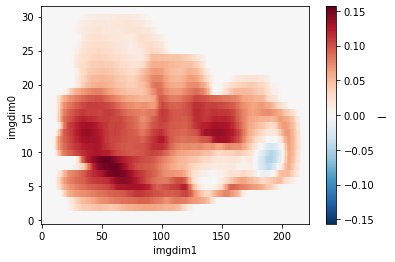

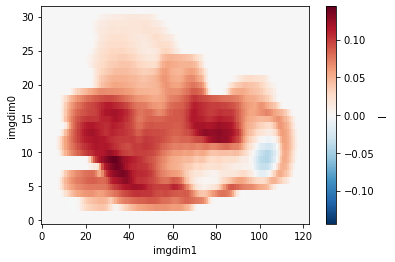

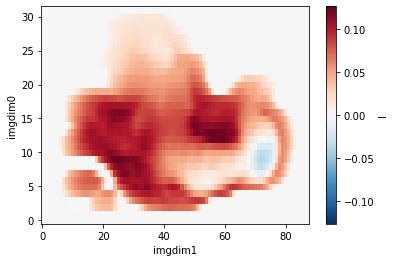

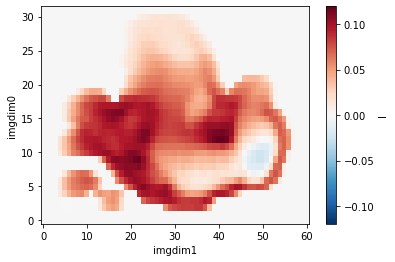

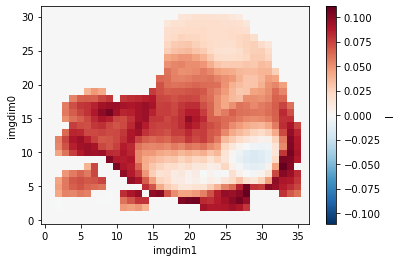

In [19]:
state_gen(x0)
forward_sensors.get_measurements(solvers_reconstruct)

for im,im2 in zip(forward_sensors.get_images('MSPI'), sensors.get_images('MSPI')):
    py.figure()
    (im.I-im2.I).plot()

In [29]:

objective_function = pyshdom.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
    sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
  state_gen.project_gradient_to_state,
    parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
  gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
  uncertainty_kwargs={'add_noise': False},
  min_bounds=min_bounds, max_bounds=max_bounds)

In [31]:
optimizer = pyshdom.optimize.Optimizer(objective_function)


In [32]:
import warnings
warnings.filterwarnings('ignore')
optimizer.minimize(x0)

      fun: 1378.7146022897982
 hess_inv: <9820x9820 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00319254, 0.0043811 , 0.00522107, ..., 0.00021031, 0.00025866,
       0.00033058])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 6
      nit: 2
     njev: 6
   status: 0
  success: True
        x: array([29.99247155, 29.99128312, 29.99044336, ..., 29.99545373,
       29.99540538, 29.99533343])

In [47]:
state_gen.get_state()

array([32.58121176, 32.58121176, 32.58121176, ..., 32.58121176,
       32.58121176, 32.58121176])

In [23]:
solvers_reconstruct[0.86]._unknown_scatterer_indices

array([[2]], dtype=int32)

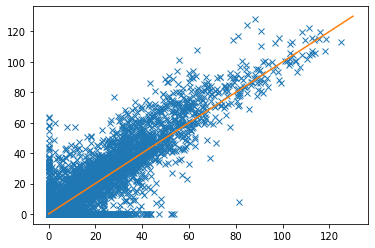

In [18]:
py.figure()
py.plot(solvers_reconstruct[0.86].medium['cloud'].extinction.data.ravel(), 
        solvers[0.86].medium['cloud'].extinction.data.ravel(),'x')
py.plot([0,130],[0,130])

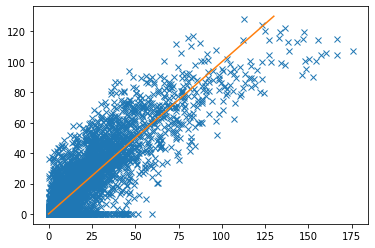

In [17]:
py.figure()
py.plot(solvers_reconstruct[0.86].medium['cloud'].extinction.data.ravel(), 
        solvers[0.86].medium['cloud'].extinction.data.ravel(),'x')
py.plot([0,130],[0,130])

In [19]:
cond = np.where(solvers_reconstruct[0.86].medium['cloud'].extinction > 0.0)
one = solvers_reconstruct[0.86].medium['cloud'].extinction.data[cond]
ref = solvers[0.86].medium['cloud'].extinction.data[cond]
print(np.mean(one), np.mean(ref), np.mean(np.abs(one - ref))/np.mean(ref))

9.759607993075381 9.989887744836532 0.40745374287011876


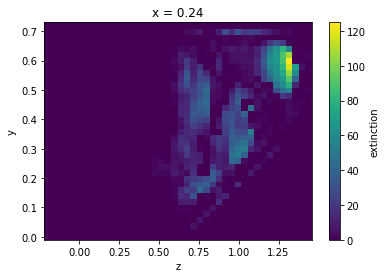

In [20]:
py.figure()
solvers_reconstruct[0.86].medium['cloud'].extinction[12,:,:-3].plot()

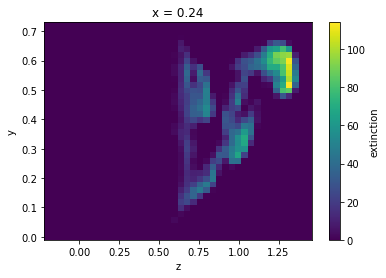

In [21]:
py.figure()
solvers[0.86].medium['cloud'].extinction[12,:,:-3].plot()